In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import RMSprop
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model
from keras.utils import get_custom_objects

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras import backend as K
from keras.initializers import Initializer
from sklearn.cluster import KMeans



class RBFLayer(Layer):
    def __init__(self, units, gamma,initializer=None, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for the centers of the RBFs
        self.centers = self.add_weight(name='centers',
                                      shape=(self.units, input_shape[-1]),
                                      initializer='uniform',
                                      trainable=True)
        self.gamma = self.add_weight(name='gamma',
                                     shape=(self.units,),
                                     initializer=Constant(
                                         value=self.gamma),
                                     # initializer='ones',
                                     trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.gamma * K.sum(H**2, axis=1))


        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, n_clusters=20, max_iter=6000):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters, max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_    
        get_custom_objects().update({'RBFLayer': RBFLayer})

In [53]:
def training_modelshot(filename):
    # load Data
    df = pd.read_csv(filename, delimiter=';')
    # Menentukan input and output
    X = df.drop(columns=["GOAL","7MACC","9MACC","6MACC","WINGACC","PIVOTACC","FASTBREAKACC"])
    y = df.GOAL
    # Membagi data set 80 : 20 train dan test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Merancang Neural Network Model
    model = Sequential()
    model.add(Flatten(input_shape=(6,)))  
    model.add(RBFLayer(6, 0.5))
    model.add(Dense(1, activation='linear'))  
    model.compile(optimizer='rmsprop', loss=mean_squared_error,metrics=['mean_squared_error', 'mean_absolute_error'])
     # Custom callback to collect metrics for plotting
    class MetricsCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            self.mse_values.append(logs['mean_squared_error'])
            self.mae_values.append(logs['mean_absolute_error'])

        def on_train_begin(self, logs=None):
            self.mse_values = []
            self.mae_values = []
    metrics_callback = MetricsCallback()
    history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_test, y_test),callbacks=[metrics_callback], verbose=0)
    model.save(f'modelacc_{os.path.splitext(os.path.basename(filename))[0]}.h5')


    # Create a figure with two subplots
    plt.figure(figsize=(16, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation Mean Squared Error
    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, metrics_callback.mse_values, label='Training MSE', color='blue')
    plt.plot(history.epoch, history.history['val_mean_squared_error'], label='Validation MSE', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
        # data prediction
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    def mean_squared_error1(y_test, pred_test):
        squared_errors = [(true - pred)**2 for true, pred in zip(y_test, pred_test)]
        mse = sum(squared_errors) / len(y_test)
        return mse
    
    mse = mean_squared_error1(y_test, pred_test)
    r2 = r2_score(y_test, pred_test)
    mae = mean_absolute_error(y_test, pred_test)
    print("Manual MSE:", mse)
    print(f"Mean Absolute Error (MAE)",mae)  
    print(f"R2 Score",r2)
    
    return model
    return model
def training_modelacc(filename):
    # load Data
    df = pd.read_csv(filename, delimiter=';')
    # Menentukan input and output
    X = df.drop(columns=["GOAL","7MSHOT","9MSHOT","6MSHOT","WINGSHOT","PIVOTSHOT","FASTBREAKSHOT"])
    y = df.GOAL
    # Membagi data set 80 : 20 train dan test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Merancang Neural Network Model
    model = Sequential()
    model.add(Flatten(input_shape=(6,)))  
    model.add(RBFLayer(6, 0.5))
    model.add(Dense(1, activation='linear'))  
    model.compile(optimizer='rmsprop', loss=mean_squared_error,metrics=['mean_squared_error', 'mean_absolute_error'])
     # Custom callback to collect metrics for plotting
    class MetricsCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            self.mse_values.append(logs['mean_squared_error'])
            self.mae_values.append(logs['mean_absolute_error'])

        def on_train_begin(self, logs=None):
            self.mse_values = []
            self.mae_values = []
    metrics_callback = MetricsCallback()
    history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_test, y_test),callbacks=[metrics_callback], verbose=0)
    model.save(f'modelacc_{os.path.splitext(os.path.basename(filename))[0]}.h5')


    # Create a figure with two subplots
    plt.figure(figsize=(16, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation Mean Squared Error
    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, metrics_callback.mse_values, label='Training MSE', color='blue')
    plt.plot(history.epoch, history.history['val_mean_squared_error'], label='Validation MSE', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
        # data prediction
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    def mean_squared_error1(y_test, pred_test):
        squared_errors = [(true - pred)**2 for true, pred in zip(y_test, pred_test)]
        mse = sum(squared_errors) / len(y_test)
        return mse
    
    mse = mean_squared_error1(y_test, pred_test)
    r2 = r2_score(y_test, pred_test)
    mae = mean_absolute_error(y_test, pred_test)
    print("Manual MSE:", mse)
    print(f"Mean Absolute Error (MAE)",mae)  
    print(f"R2 Score",r2)
    
    return model

Position:  CB.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


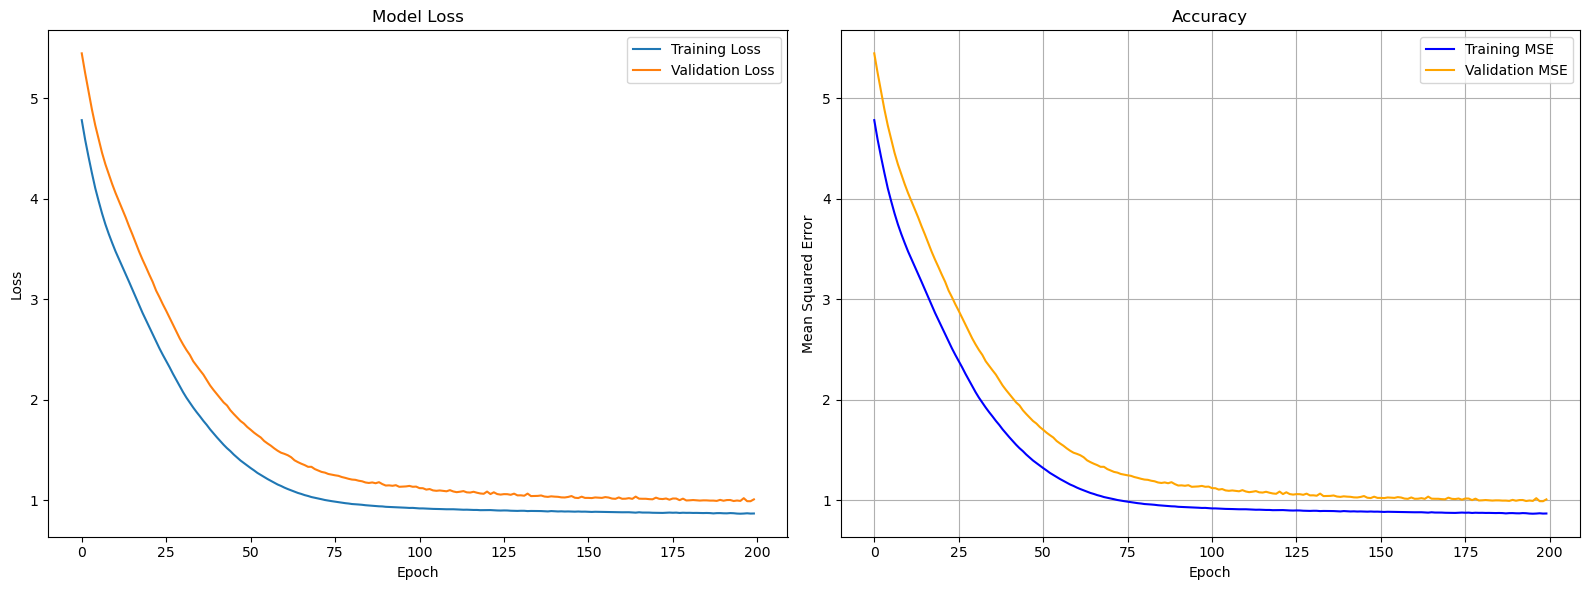

9/9 [==============================] - 0s 1ms/step
Manual MSE: [1.0089345]
Mean Absolute Error (MAE) 0.6502849766912386
R2 Score 0.7914894739541157

Position:  LB.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


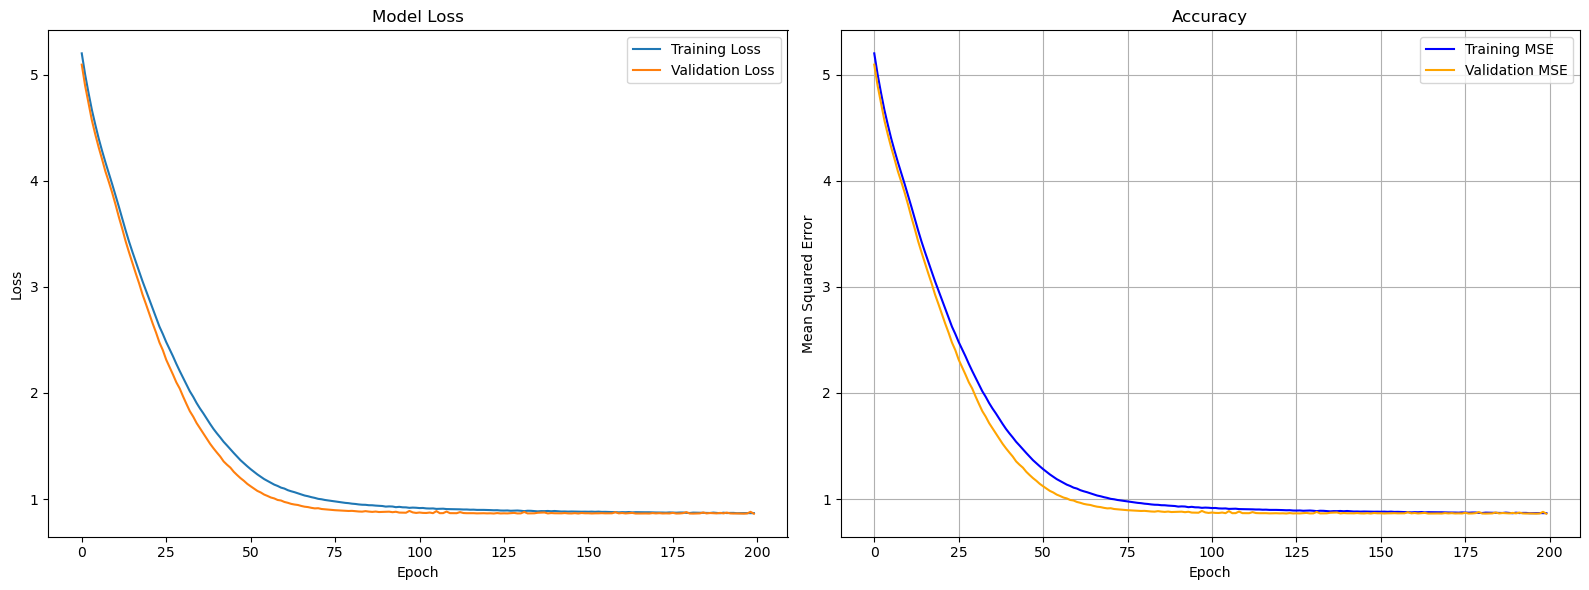

10/10 [==============================] - 0s 1ms/step
Manual MSE: [0.8619809]
Mean Absolute Error (MAE) 0.6328702172301462
R2 Score 0.8148203376304485

Position:  LW.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


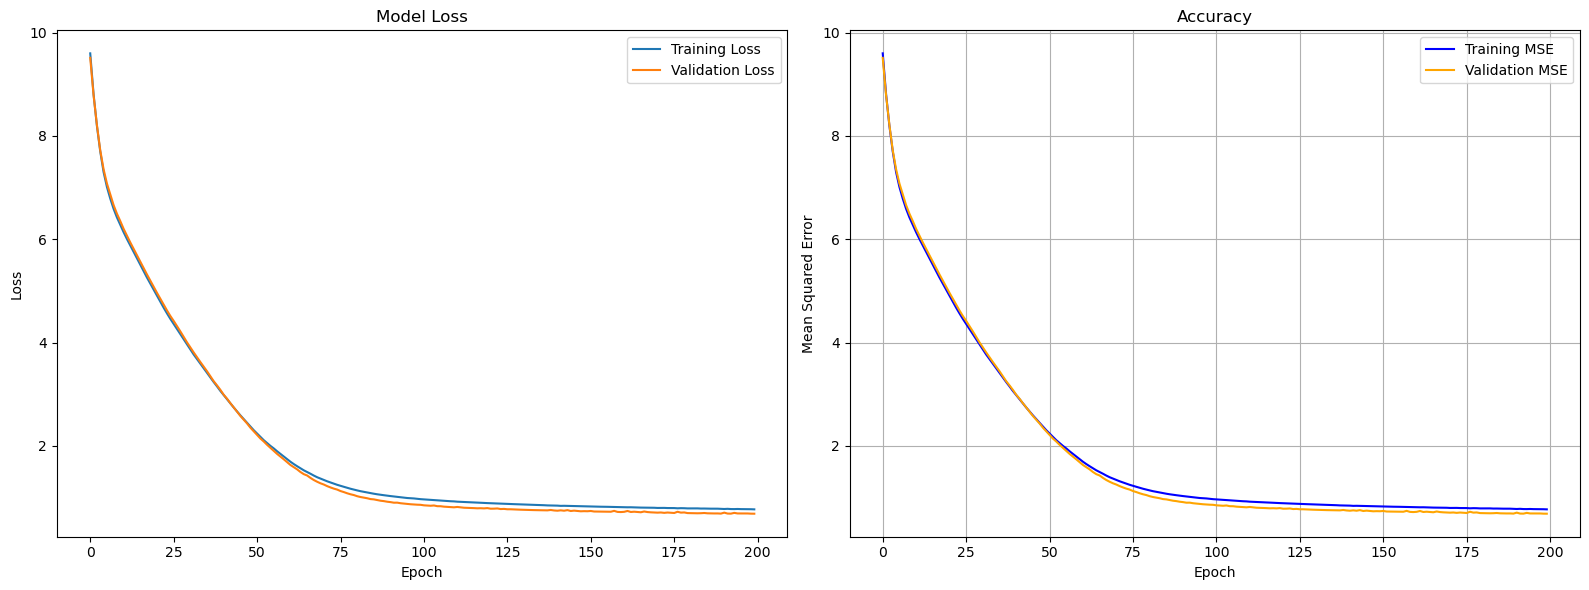

8/8 [==============================] - 0s 1ms/step
Manual MSE: [0.6870205]
Mean Absolute Error (MAE) 0.5378679171852444
R2 Score 0.9012699323625044

Position:  P.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


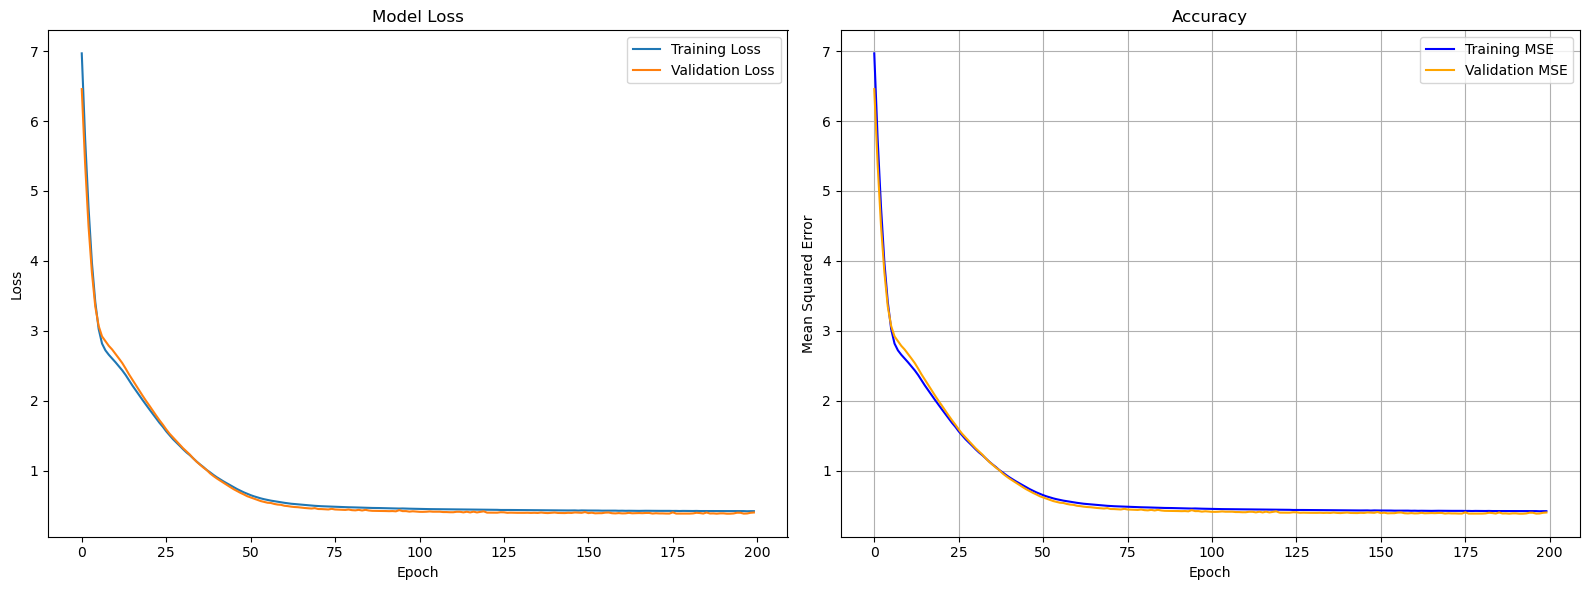

10/10 [==============================] - 0s 1ms/step
Manual MSE: [0.3994351]
Mean Absolute Error (MAE) 0.4375712713774513
R2 Score 0.8737971581312203

Position:  RB.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


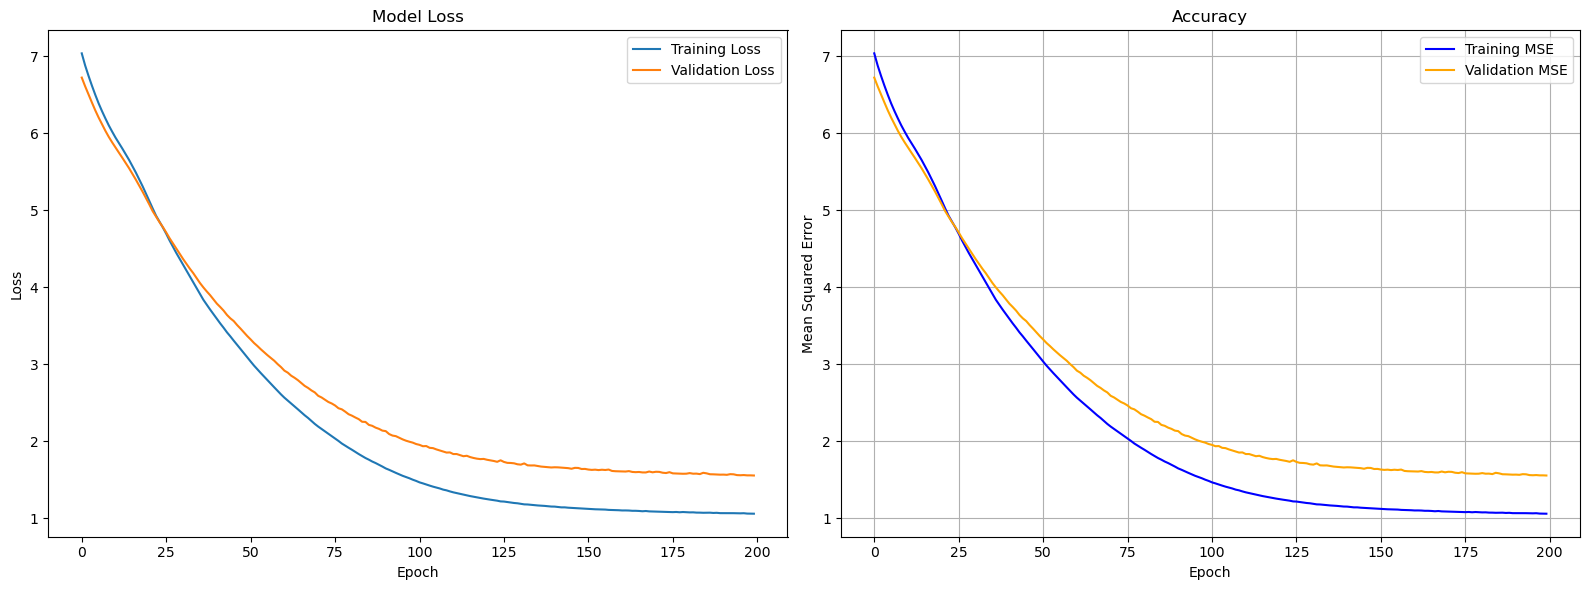

7/7 [==============================] - 0s 997us/step
Manual MSE: [1.5571325]
Mean Absolute Error (MAE) 0.8173693857409737
R2 Score 0.7329405941524894

Position:  RW.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


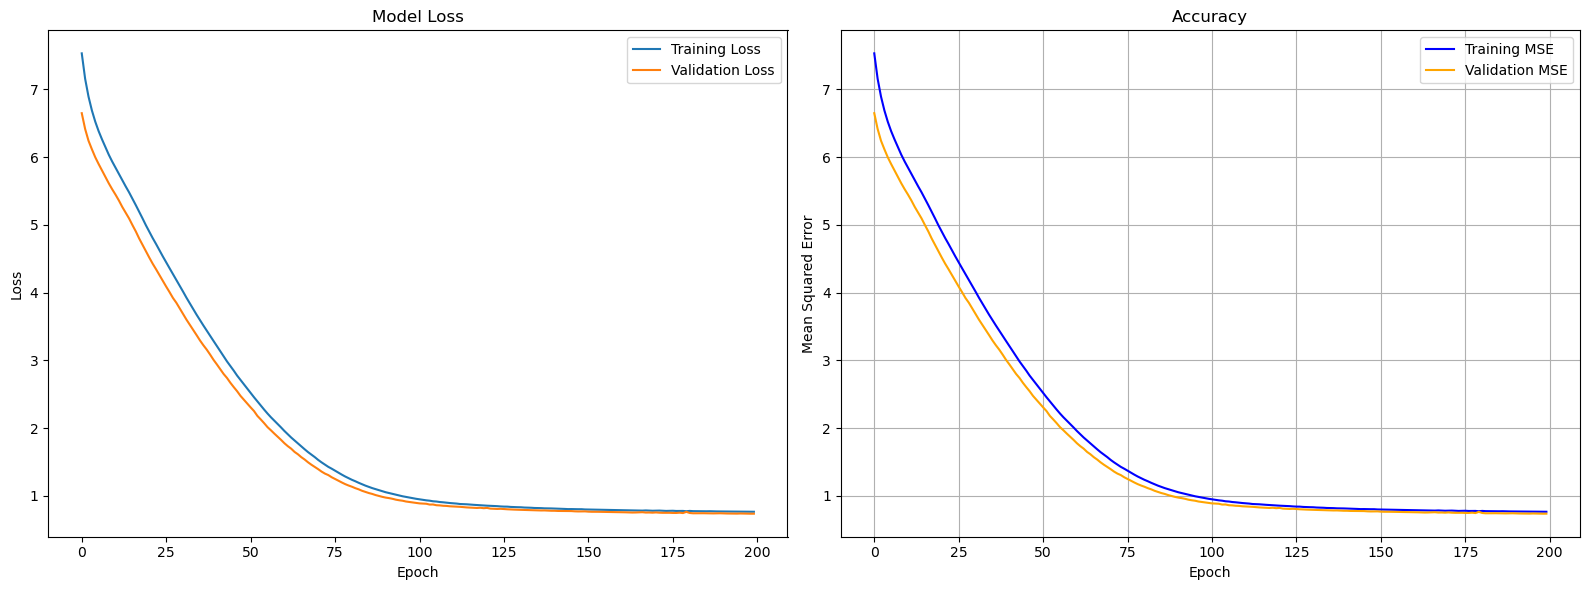

8/8 [==============================] - 0s 1ms/step
Manual MSE: [0.7354947]
Mean Absolute Error (MAE) 0.5573761302491893
R2 Score 0.8722579637429715



In [54]:
for i in os.listdir('data/'):
    print('Position: ', i.split(',')[0])
    training_modelshot('data/'+i)
    print('')

Position:  CB.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


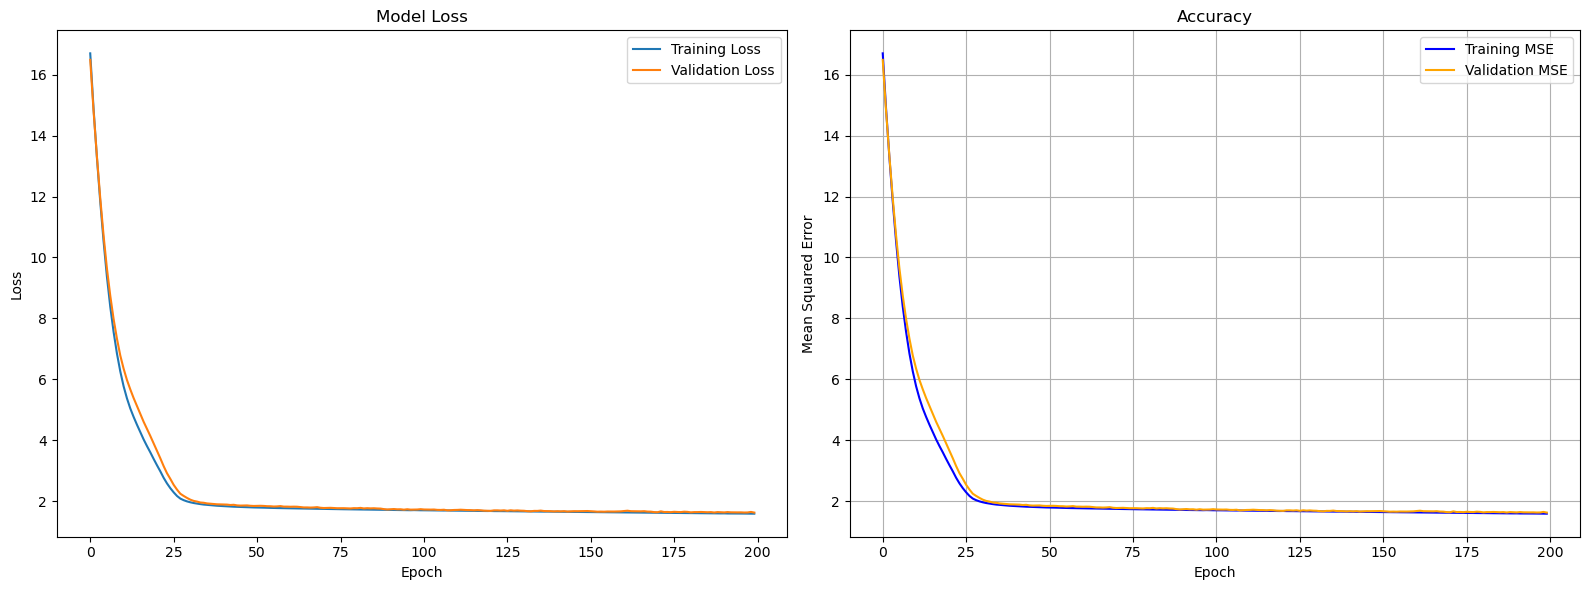

9/9 [==============================] - 0s 1ms/step
Manual MSE: [1.6292939]
Mean Absolute Error (MAE) 0.8665814240311467
R2 Score 0.6632833679212973

Position:  LB.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


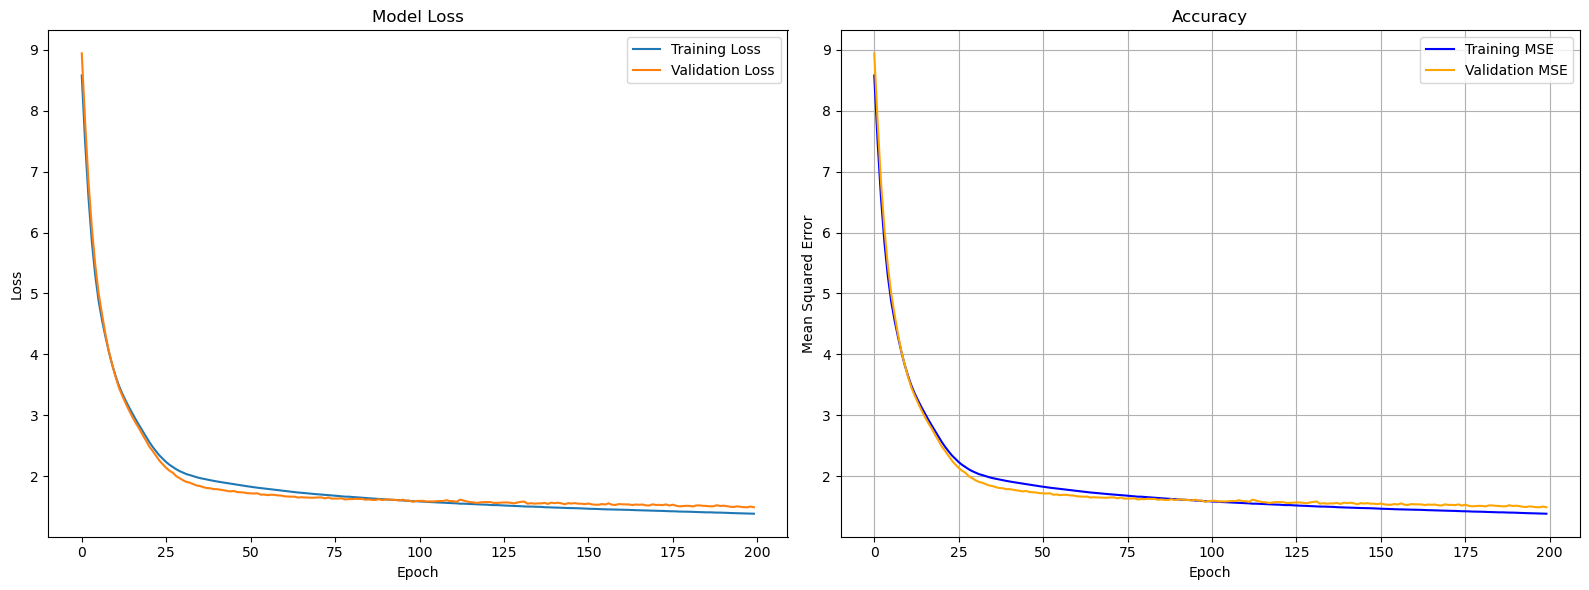

10/10 [==============================] - 0s 1ms/step
Manual MSE: [1.4900602]
Mean Absolute Error (MAE) 0.8195855485287723
R2 Score 0.6798902226605891

Position:  LW.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


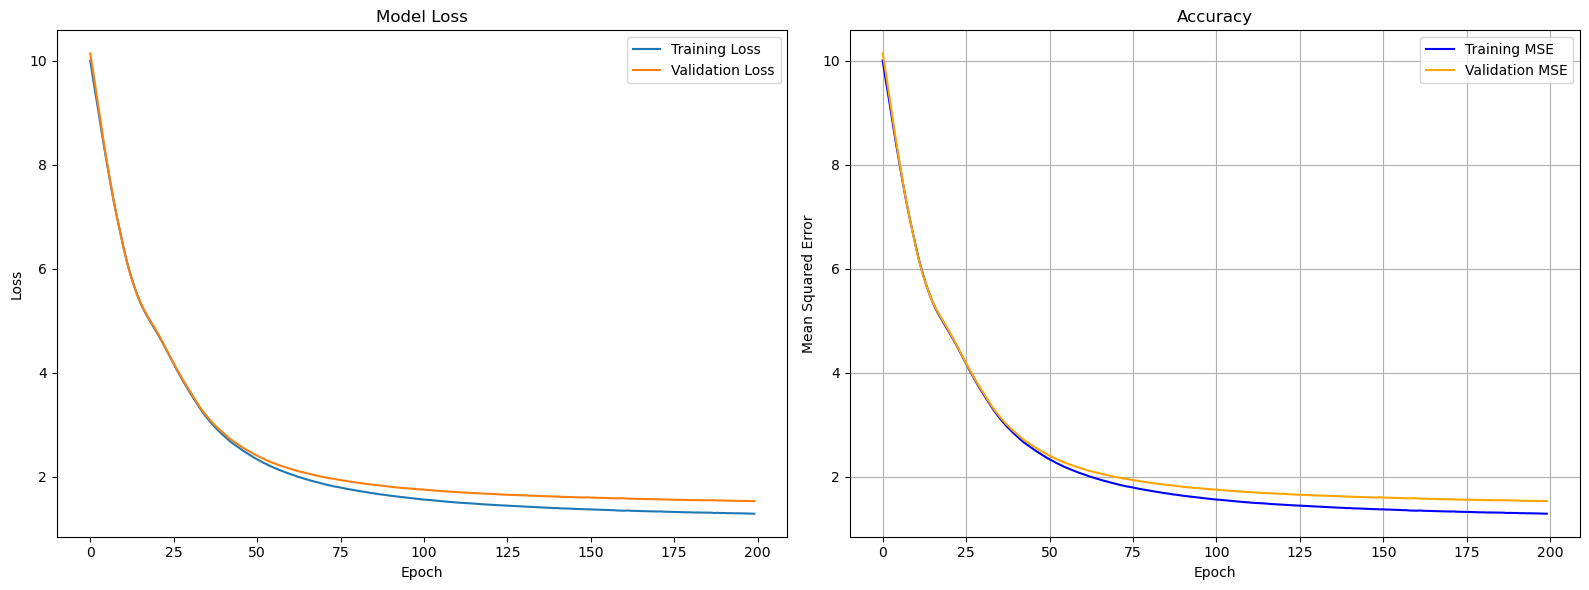

8/8 [==============================] - 0s 1ms/step
Manual MSE: [1.5292319]
Mean Absolute Error (MAE) 0.7672986211984054
R2 Score 0.7802380358620498

Position:  P.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


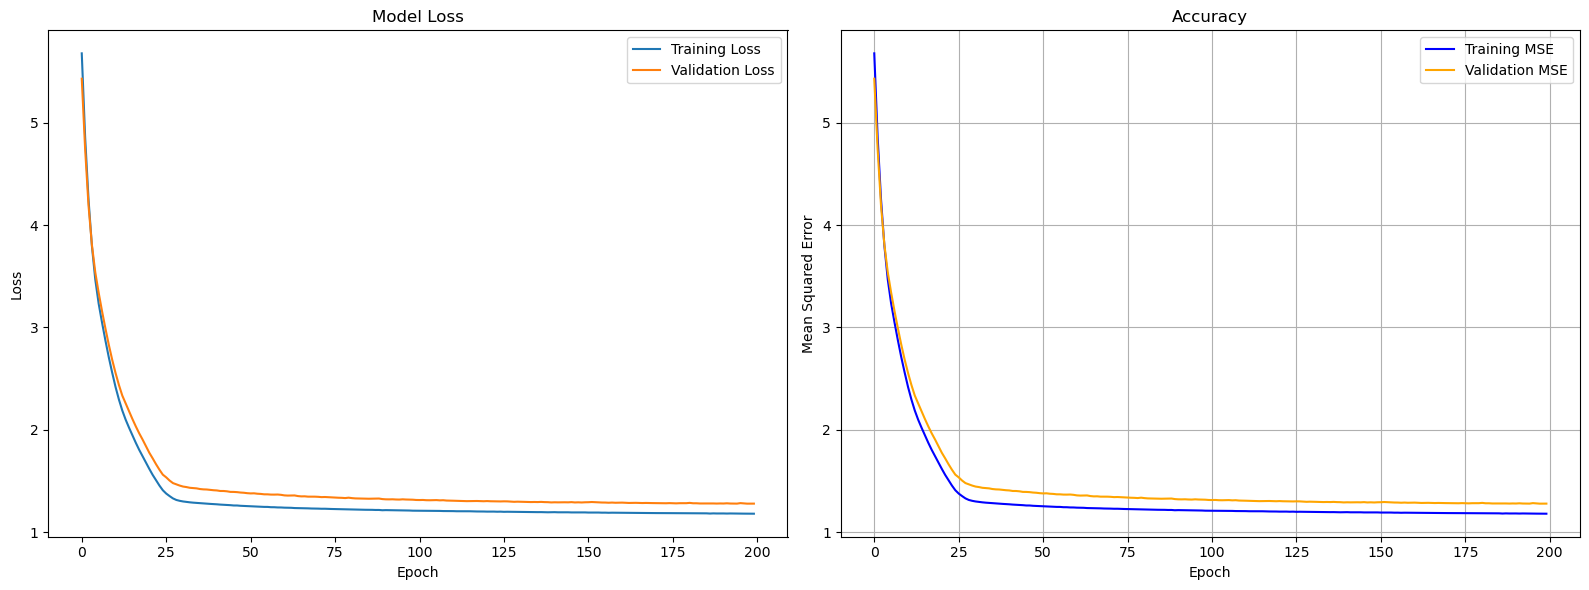

10/10 [==============================] - 0s 1ms/step
Manual MSE: [1.280913]
Mean Absolute Error (MAE) 0.7022618697164884
R2 Score 0.5952908460972807

Position:  RB.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


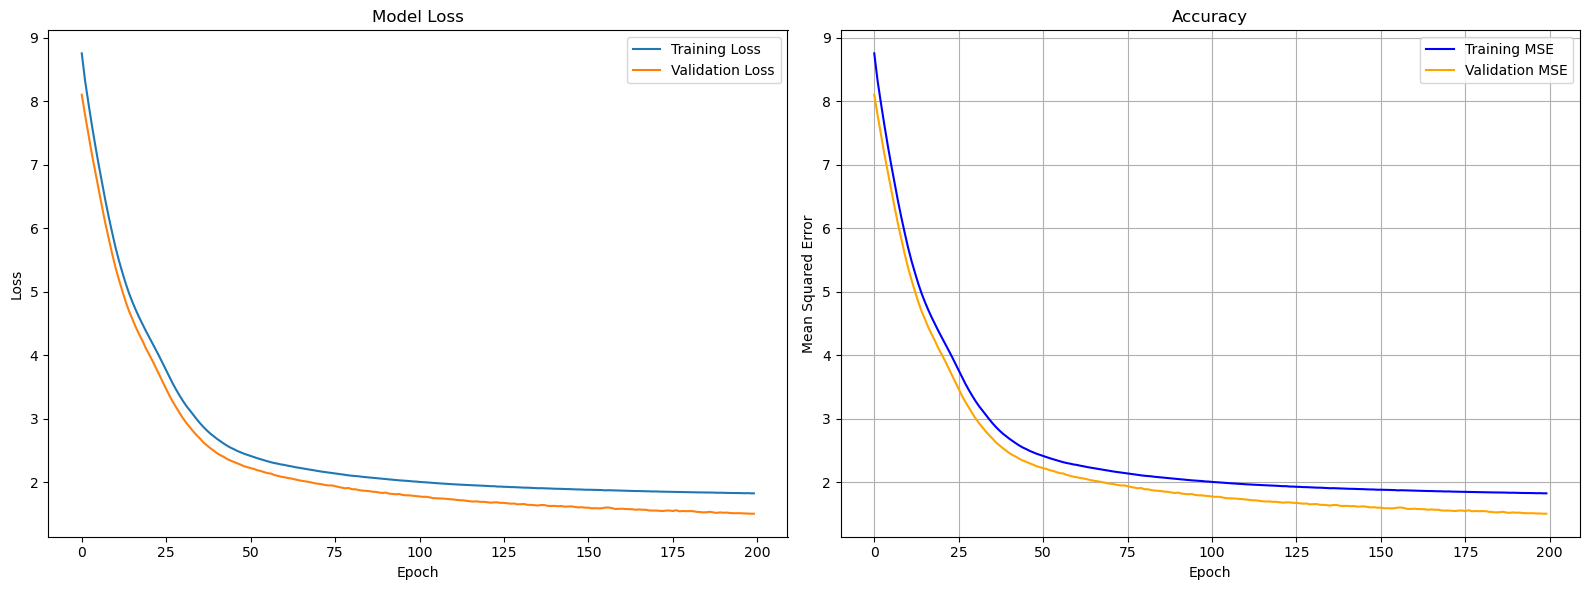

7/7 [==============================] - 0s 1ms/step
Manual MSE: [1.501297]
Mean Absolute Error (MAE) 0.8145160377025604
R2 Score 0.7425166242349396

Position:  RW.csv


C:\Users\Wandi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


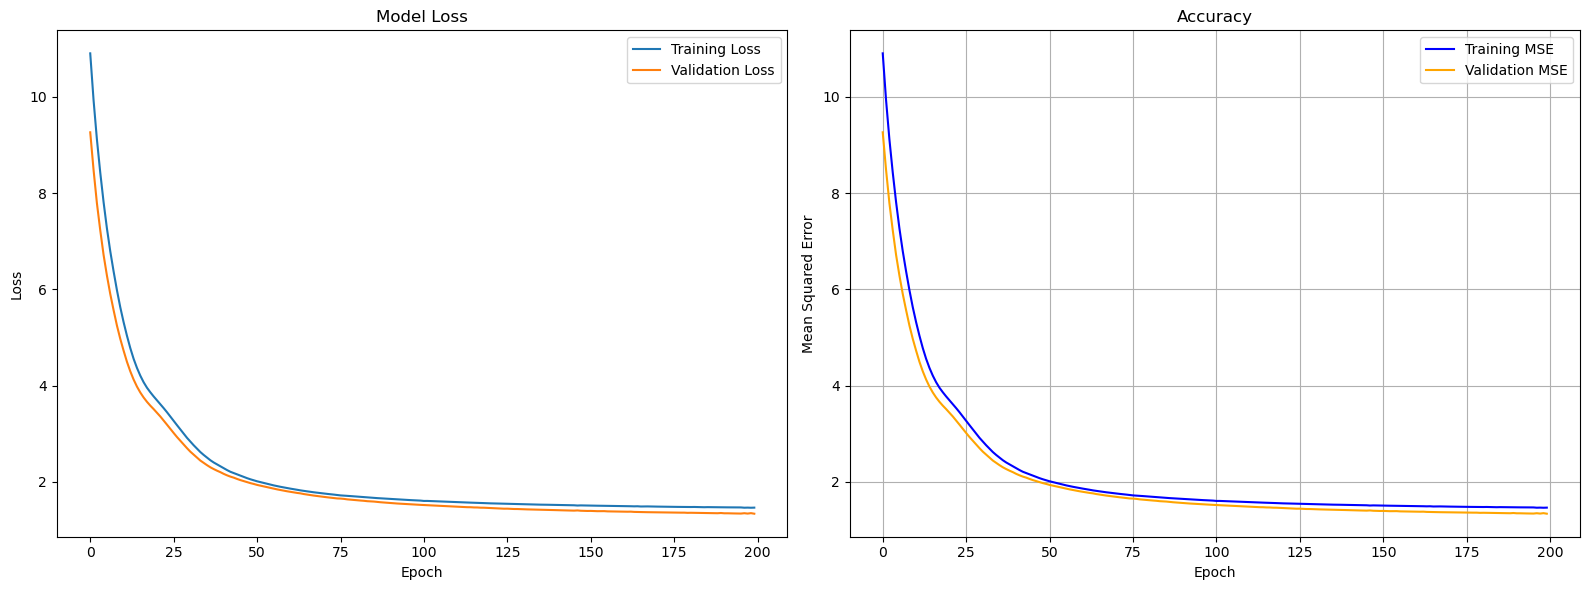

8/8 [==============================] - 0s 1ms/step
Manual MSE: [1.3368459]
Mean Absolute Error (MAE) 0.7706167171830717
R2 Score 0.767814155066828



In [55]:
for i in os.listdir('data/'):
    print('Position: ', i.split(',')[0])
    training_modelacc('data/'+i)
    print('')

In [5]:
urlshot = 'https://raw.githubusercontent.com/ravsssh/HandballPrediction/main/Handball%20Prediction/data/Sensitivity/SHOTATTEMPT.csv'
shot_df = pd.read_csv(urlshot, delimiter = ';')
# Normalisasi nilai 
scaler = MinMaxScaler()
shot_df = scaler.fit_transform(shot_df)
shot_sensitivity = model.predict(shot_df)
print(shot_sensitivity)

2/2 [==============================] - 0s 2ms/step
[[0.16640592]
 [0.4444332 ]
 [0.7468698 ]
 [1.0186324 ]
 [1.1980276 ]
 [1.239218  ]
 [1.1311703 ]
 [0.90243244]
 [0.60893464]
 [0.16640592]
 [0.3915267 ]
 [0.61754227]
 [0.80975676]
 [0.95215917]
 [1.0453999 ]
 [1.0998139 ]
 [1.1282687 ]
 [1.1416504 ]
 [0.16640592]
 [0.18007767]
 [0.1946019 ]
 [0.2075038 ]
 [0.21742725]
 [0.2241509 ]
 [0.22820294]
 [0.2303884 ]
 [0.23144746]
 [0.16640592]
 [0.16524982]
 [0.16431355]
 [0.1636492 ]
 [0.16323113]
 [0.16299605]
 [0.16287756]
 [0.16282368]
 [0.16280174]
 [0.16640592]
 [1.158318  ]
 [2.3567681 ]
 [3.5918393 ]
 [4.6188793 ]
 [5.1936965 ]
 [5.166179  ]
 [4.543714  ]
 [3.4879818 ]
 [0.16640592]
 [0.5358269 ]
 [0.9186833 ]
 [1.2524265 ]
 [1.5050228 ]
 [1.6736779 ]
 [1.7739326 ]
 [1.8272946 ]
 [1.8528246 ]]


In [6]:
pd.DataFrame(shot_sensitivity).to_csv('sensitivitasshot.csv', index=False)